In [1]:
import glob
import matplotlib.pyplot as plt
import os
import re
import pandas
from pandas import DataFrame
from pathlib import Path
import scyjava
import seaborn
import tkinter as tk
from tkinter import filedialog, simpledialog, messagebox
import csv
import numpy as np
from skimage.measure import find_contours, label

# test graph 

In [59]:
def define_main_path():
    # Dialog window to get the path of the working directory
    root = tk.Tk()
    root.withdraw()
    # Set the path to the directory containing the images
    directory_path = filedialog.askdirectory()
    return directory_path

def transpose_dataframe(df, x_dim):
    df_transposed = df.transpose()
    df_cleaned = df_transposed.drop(["time"])
    for i in range(0, len(df)):
        x_value = df["time"][i]
        df_cleaned.rename(columns={df_cleaned.columns[i]: f'{x_value}h'}, inplace=True)
    return df_cleaned


def plot_mean_se_curves2(df, save_dir, conditions_base=['OSBP+', 'LC3+', 'OSBP+_LC3+'], time_col='time', size = (5, 4)):
    plt.figure(figsize=size)
    
    time = df[time_col]
    palette = seaborn.color_palette("Set2", len(conditions_base))

    for i, cond in enumerate(conditions_base):
        # Identify replicates
        cond_cols = [col for col in df.columns if cond in col]
        cond_data = df[cond_cols]
        
        # Calculate mean and SE
        mean = cond_data.mean(axis=1)
        se = cond_data.sem(axis=1)
        
        plt.plot(time, mean, label=cond, color=palette[i], linewidth=2)
        plt.scatter(time, mean, color=palette[i], s=70, edgecolor='black', zorder=3)
        plt.errorbar(time, mean, yerr=se, fmt='none', ecolor=palette[i], elinewidth=1.5, capsize=5, capthick=1.5)
        
    #plt.title("Colocalization over Time")
    plt.xlabel("Time (h)")
    plt.ylabel("% Colocalization")
    plt.ylim(0, df.drop(columns=[time_col]).max().max() * 1.2)
    plt.legend()
    plt.grid(False)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()

    # Save outputs
    tif_path = os.path.join(save_dir, "coloc.tif")
    svg_path = os.path.join(save_dir, "coloc.svg")
    plt.savefig(tif_path)
    plt.savefig(svg_path)
    plt.show()


def plot_histogram(df, save_dir, size = (3, 4), errorbars=True):
    plt.figure(figsize=size)
    custom_palette = {
        "OSBP+": "#66c2a5",
        "LC3+": "#fc8d62",
        "LC3+_OSBP+": "#8da0cb"
    }
    if errorbars==True:
        seaborn.barplot(data = df, errorbar = "se", capsize=0.2, errwidth=1.5, linewidth=0.5, palette=custom_palette, edgecolor="black")
    elif errorbars==False:
        seaborn.barplot(data = df, errorbar = None, linewidth=0.5, palette=custom_palette, edgecolor="black")
    seaborn.swarmplot(data = df, size=8, linewidth=1.2, legend=False, palette=custom_palette, edgecolor="black")

    plt.ylabel("% Colocalization")
    plt.grid(False)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Save outputs
    tif_path = os.path.join(save_dir, "coloc2.tif")
    svg_path = os.path.join(save_dir, "coloc2.svg")
    plt.savefig(tif_path)
    plt.savefig(svg_path)
    plt.show()

In [3]:
directory_path = define_main_path()

In [6]:
df_path = f"{directory_path}/quantif_coloc.csv"
df = pandas.read_csv(df_path)

In [5]:
x_dim = f"time"
df_transposed = transpose_dataframe(df, x_dim)
df_transposed.head()

,1h,6h,20h
OSBP+_exp1,5.726257,11.208150,4.285714
OSBP+_exp2,9.689922,13.011150,7.509881
OSBP+_exp3,7.476636,11.325300,12.056740
LC3+_exp1,14.106150,6.259098,1.587302
LC3+_exp2,8.527132,4.460967,1.976285


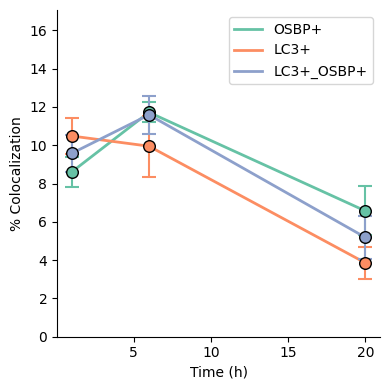

In [47]:
plot_mean_se_curves2(df, directory_path, conditions_base=['OSBP+', 'LC3+', 'LC3+_OSBP+'], time_col='time', size = (4, 4))

In [29]:
conditions = choose_conditions(df)
if conditions:
    plot_mean_se_dots(df, directory_path, conditions)
else:
    print("No conditions selected.")

No conditions selected.


In [4]:
df_path2 = f"{directory_path}/quantif_coloc2.csv"
df2 = pandas.read_csv(df_path2)

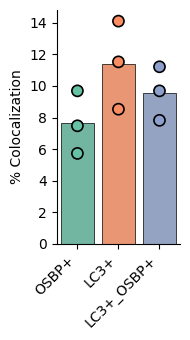

In [58]:
plot_histogram(df2, directory_path, size = (2, 3.5), errorbars=False)

# Testing area

In [ ]:
def choose_conditions(df):
    # Extract base condition names
    condition_bases = sorted({col.split('_exp')[0] for col in df.columns if '_exp' in col})

    result_holder = {'selected': []}

    def on_select():
        result_holder['selected'] = [cond for cond, var in zip(condition_bases, varlist) if var.get()]
        win.destroy()

    win = tk.Tk()
    win.title("Select Conditions")
    tk.Label(win, text="Select conditions to plot:").pack()

    varlist = []
    for cond in condition_bases:
        var = tk.BooleanVar()
        tk.Checkbutton(win, text=cond, variable=var).pack(anchor="w")
        varlist.append(var)

    tk.Button(win, text="OK", command=on_select).pack()

    # Make sure window pops up and works in notebooks
    win.lift()
    win.attributes("-topmost", True)
    win.after_idle(win.attributes, "-topmost", False)
    win.wait_window()

    return result_holder['selected']

def plot_mean_se_dots(df, save_dir, selected_conditions, time_col='time'):
    plt.figure(figsize=(6, 4))
    
    time = df[time_col]
    palette = seaborn.color_palette("Set2", len(selected_conditions))

    for i, cond in enumerate(selected_conditions):
        cond_cols = [col for col in df.columns if cond in col]
        cond_data = df[cond_cols]

        mean = cond_data.mean(axis=1)
        se = cond_data.sem(axis=1)

        plt.plot(time, mean, label=cond, color=palette[i], linewidth=2)
        plt.scatter(time, mean, color=palette[i], s=50, edgecolor='black', zorder=3)
        plt.errorbar(time, mean, yerr=se, fmt='none', ecolor=palette[i], elinewidth=1.5, capsize=5, capthick=1.5)

    plt.title("Colocalization over Time")
    plt.xlabel("Time (h)")
    plt.ylabel("% Colocalization")
    plt.ylim(0, df.drop(columns=[time_col]).max().max() * 1.2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save outputs
    tif_path = os.path.join(save_dir, "coloc.tif")
    svg_path = os.path.join(save_dir, "coloc.svg")
    plt.savefig(tif_path)
    plt.savefig(svg_path)
    plt.show()


## attempt to concatenate csv file from multiple directories into a single csv file

In [ ]:
rawintden = []
folder_list = os.listdir(directory_path)
for folder in folder_list:
    folder_path = os.path.join(directory_path, folder)
    file_pattern = os.path.join(folder_path, "*.csv")
    file_list = glob.glob(file_pattern)
    basename_folder = os.path.basename(folder_path)
    for file_path in file_list:
        df = pandas.read_csv(file_path)
        basename = os.path.basename(file_path)
        corename = os.path.splitext(basename)
        if basename.endswith("1h_rawintden.csv"):
            timepoint = "1h"
        else:
            timepoint = "24h"
        column_name = f"exp_{basename_folder[-1]}_rawintden_{timepoint}"
        df.rename(columns = {"RawIntDen" : f"{column_name}"}, inplace=True)
        rawintden.append(df[column_name])

df_raw = pandas.concat(rawintden, axis =1)
output = f"{directory_path}/rawintden_concat.csv"
df_raw.to_csv(output)        

In [ ]:
volumes = []
folder_list = os.listdir(directory_path)
for folder in folder_list:
    if not folder.endswith(".csv"):
        folder_path = os.path.join(directory_path, folder)
        basename_folder = os.path.basename(folder_path)
        subfolder_list = os.listdir(folder_path)
        for subfolder in subfolder_list:
            if not subfolder.endswith(".csv"):
                folder_path2 = os.path.join(folder_path, subfolder)
                csv_path = f"{folder_path2}/{subfolder}.csv"
                df = pandas.read_csv(csv_path)
                if subfolder.endswith("1h"):
                    timepoint = "1h"
                else:
                    timepoint = "24h"
                column_name = f"exp_{basename_folder[-1]}_volume_{timepoint}"
                df.rename(columns = {"bacterial_volume" : f"{column_name}"}, inplace=True)
                volumes.append(df[column_name])
            
df_volumes = pandas.concat(volumes, axis =1)
output = f"{directory_path}/volumes_concat.csv"
df_volumes.to_csv(output)                 